In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [ ]:
url = "https://github.com/emoryhubbard/express-autocode-api/raw/main/code-classifier-dataset.tar.gz"

dataset = tf.keras.utils.get_file("code-classifier-dataset", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'code-classifier-dataset')
train_dir = os.path.join(dataset_dir, 'train')

62934/62934 [==============================] - 0s 0us/step


In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'code-classifier-dataset/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 1490 files belonging to 2 classes.
Using 1192 files for training.


In [ ]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'code-classifier-dataset/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 1490 files belonging to 2 classes.
Using 298 files for validation.


In [ ]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'code-classifier-dataset/test',
    batch_size=batch_size)

Found 372 files belonging to 2 classes.


In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [ ]:
max_features = 10000
sequence_length = 250

'''vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)'''

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
embedding_dim = 16

In [ ]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
38/38 [==============================] - 9s 157ms/step - loss: 0.6924 - binary_accuracy: 0.5260 - val_loss: 0.6910 - val_binary_accuracy: 0.7584
Epoch 2/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6901 - binary_accuracy: 0.5872 - val_loss: 0.6901 - val_binary_accuracy: 0.4564
Epoch 3/10
38/38 [==============================] - 0s 4ms/step - loss: 0.6879 - binary_accuracy: 0.5730 - val_loss: 0.6883 - val_binary_accuracy: 0.4564
Epoch 4/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6855 - binary_accuracy: 0.5906 - val_loss: 0.6858 - val_binary_accuracy: 0.4564
Epoch 5/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6829 - binary_accuracy: 0.6233 - val_loss: 0.6827 - val_binary_accuracy: 0.6174
Epoch 6/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6788 - binary_accuracy: 0.6552 - val_loss: 0.6791 - val_binary_accuracy: 0.7752
Epoch 7/10
38/38 [==============================] - 0s 5ms/step - loss: 0.

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

12/12 [==============================] - 0s 3ms/step - loss: 0.6659 - binary_accuracy: 0.7419
Loss:  0.6659321188926697
Accuracy:  0.7419354915618896


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

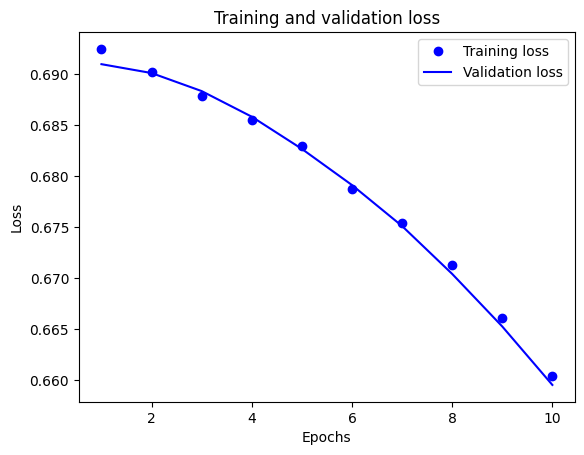

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

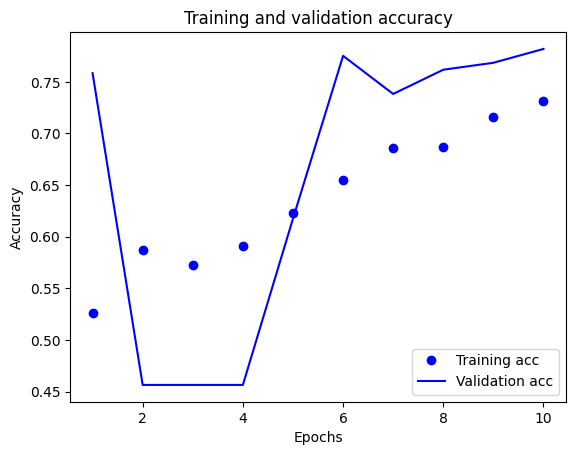

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

12/12 [==============================] - 0s 4ms/step - loss: 0.6659 - accuracy: 0.7419
0.7419354915618896


In [ ]:
examples = [
  "        const parsedData = JSON.parse(jsonData);",
  "In this example, data.json is assumed to be in your root directory, and it contains valid JSON data. The function readJsonFromFile reads the content of the file synchronously, parses it using JSON.parse, and returns the parsed JSON data.",
  "    } catch (error) {"
]

export_model.predict(examples)

1/1 [==============================] - 0s 117ms/step


array([[0.5154504],
       [0.4539978],
       [0.512731 ]], dtype=float32)